In [46]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [47]:
df=pd.read_csv(r"D:\Projects\Stock_analysis\data\cleaned_stock_data.csv")
df.head()

,Unnamed: 0,Close
0,0,6.424605
1,1,6.435715
2,2,6.333344
3,3,6.321635
4,4,6.363664


In [48]:
ts_data = df['Close']

In [49]:
train_size = int(len(ts_data) * 0.8)
train_data = ts_data[:train_size]
test_data = ts_data[train_size:]

#### ARIMA

In [50]:
arima_model = ARIMA(train_data, order=(5, 1, 0))
arima_fit = arima_model.fit()
arima_forecast = arima_fit.forecast(steps=len(test_data))
arima_forecast

2817    118.156498
2818    118.156433
2819    118.121851
2820    118.151226
2821    118.141893
           ...    
3517    118.143794
3518    118.143794
3519    118.143794
3520    118.143794
3521    118.143794
Name: predicted_mean, Length: 705, dtype: float64

#### SARIMA

if seasonal data is given

In [51]:
sarima_model = SARIMAX(train_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_fit = sarima_model.fit(disp=False)
sarima_forecast = sarima_fit.forecast(steps=len(test_data))
sarima_forecast

2817    118.487742
2818    118.419905
2819    118.449546
2820    118.536578
2821    118.771407
           ...    
3517    161.225288
3518    161.158215
3519    161.123758
3520    161.170050
3521    161.165778
Name: predicted_mean, Length: 705, dtype: float64

In [59]:
df_pf=pd.read_csv(r"D:\Projects\Stock_analysis\data\prophet.csv")
df_pf['ds'] = pd.to_datetime(df_pf['ds'], dayfirst=True)
df_pf.head(100)


,Unnamed: 0,index,ds,y
0,0,1970-01-01 00:00:00.000000000,2010-01-04,6.424605
1,1,1970-01-01 00:00:00.000000001,2010-01-05,6.435715
2,2,1970-01-01 00:00:00.000000002,2010-01-06,6.333344
3,3,1970-01-01 00:00:00.000000003,2010-01-07,6.321635
4,4,1970-01-01 00:00:00.000000004,2010-01-08,6.363664
...,...,...,...,...
95,95,1970-01-01 00:00:00.000000095,2010-05-20,7.137584
96,96,1970-01-01 00:00:00.000000096,2010-05-21,7.274476
97,97,1970-01-01 00:00:00.000000097,2010-05-24,7.407765
98,98,1970-01-01 00:00:00.000000098,2010-05-25,7.361533


In [58]:

prophet_train = df_pf[:train_size]
prophet_test = df_pf[train_size:]

prophet_model = Prophet(daily_seasonality=True)
prophet_model.fit(prophet_train)
prophet_future = prophet_model.make_future_dataframe(periods=len(prophet_test), include_history=False)
prophet_forecast_df = prophet_model.predict(prophet_future)
prophet_forecast = prophet_forecast_df['yhat']
prophet_forecast.index = test_data.index

20:26:22 - cmdstanpy - INFO - Chain [1] start processing
20:26:25 - cmdstanpy - INFO - Chain [1] done processing


In [62]:
import numpy as np
from sklearn.metrics import mean_absolute_error,mean_squared_error

def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{model_name} Performance:")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAE: {mae:.2f}\n")
    return rmse

print("--- Model Evaluation Results ---")
rmse_arima = evaluate_model(test_data, arima_forecast, "ARIMA")
rmse_sarima = evaluate_model(test_data, sarima_forecast, "SARIMA")
rmse_prophet = evaluate_model(test_data, prophet_forecast, "Prophet")

# Create a summary DataFrame
results_df = pd.DataFrame({
    'Model': ['ARIMA', 'SARIMA', 'Prophet'],
    'RMSE': [rmse_arima, rmse_sarima, rmse_prophet]
}).sort_values(by='RMSE')

print("\n--- Final Comparison ---")
print(results_df)


--- Model Evaluation Results ---
ARIMA Performance:
  RMSE: 41.98
  MAE: 37.23

SARIMA Performance:
  RMSE: 20.98
  MAE: 17.39

Prophet Performance:
  RMSE: 17.68
  MAE: 14.50


--- Final Comparison ---
     Model       RMSE
2  Prophet  17.681796
1   SARIMA  20.975464
0    ARIMA  41.977409


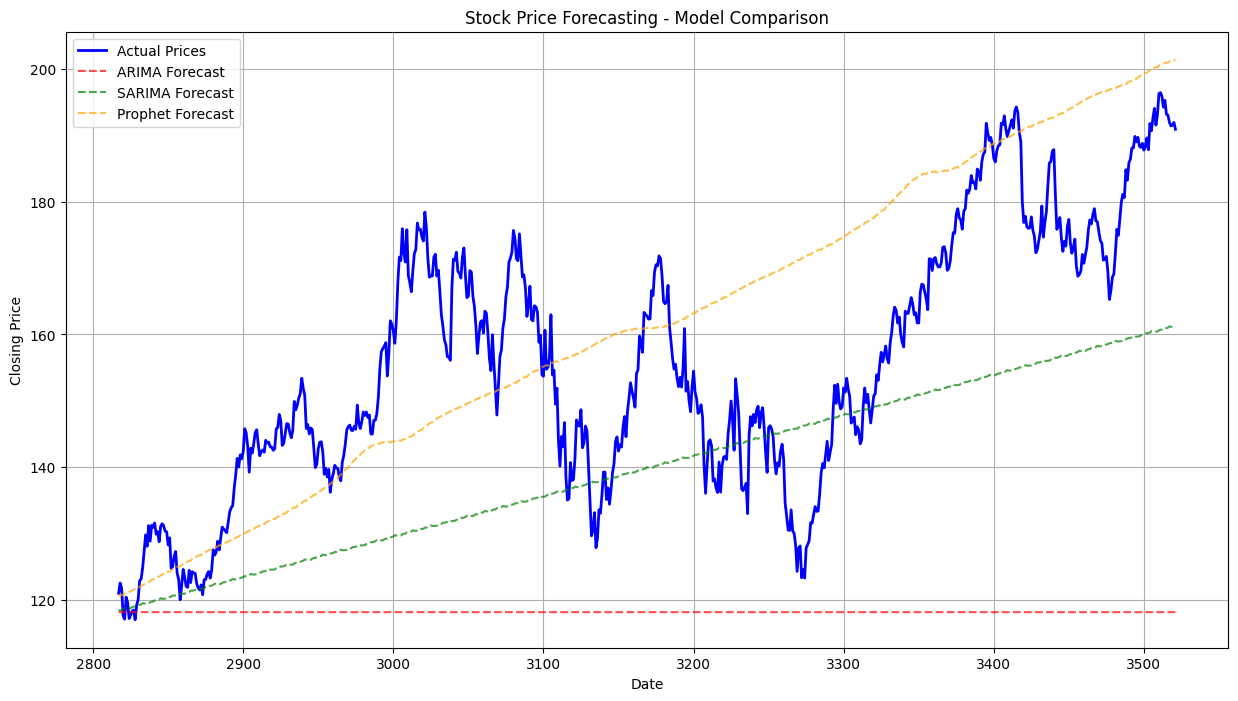

In [63]:
plt.figure(figsize=(15, 8))
plt.plot(test_data.index, test_data.values, label='Actual Prices', color='blue', linewidth=2)
plt.plot(arima_forecast.index, arima_forecast.values, label='ARIMA Forecast', color='red', linestyle='--', alpha=0.7)
plt.plot(sarima_forecast.index, sarima_forecast.values, label='SARIMA Forecast', color='green', linestyle='--', alpha=0.7)
plt.plot(prophet_forecast.index, prophet_forecast.values, label='Prophet Forecast', color='orange', linestyle='--', alpha=0.7)

plt.title('Stock Price Forecasting - Model Comparison')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.show()